In [12]:
import sys
sys.path.append('/Users/marjoriesayer/anaconda/envs/mids_hw1/lib/python2.7/site-packages')

In [115]:
%matplotlib inline

# General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

Load the Crime data.

In [116]:
crime_data = []
crime_labels = []
with open("../../train.csv", "rb") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    first_row = True
    for row in reader:
        data = [y for x, y in enumerate(row) if x != 1]
        name = [y for x, y in enumerate(row) if x == 1]
        
        if first_row:
            first_row = False
            feature_names = data
            print feature_names
        else:
            crime_data.append(data)
            crime_labels.append(name)

['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']


In [117]:
# Divide the Crime training set into train data, test data, dev data
train_data, train_labels = crime_data[:500000], crime_labels[:500000]
crime_test, crime_test_labels = crime_data[500000:], crime_labels[500000:]
num_test = len(crime_test)
print num_test
dev_data, dev_labels = crime_test[:num_test/2], crime_test_labels[:num_test/2]
test_data, test_labels = crime_test[num_test/2:], crime_test_labels[num_test/2:]
mini_train_data, mini_train_labels = crime_data[200000:300000], crime_labels[200000:300000]

print "Size of train data: ", len(train_data)
print "Size of dev data: ", len(dev_data)
print "Size of test data: ", len(test_data)

378049
Size of train data:  500000
Size of dev data:  189024
Size of test data:  189025


In [118]:
from datetime import datetime
def convert_date(date_val):
    date_list = []
    date, time = date_val.split()
    date_list.append(int(date.split('-')[0]))
    date_list.append(int(date.split('-')[1]))
    date_list.append(int(date.split('-')[2]))
    time_in_min = int(time.split(':')[0]) * 60.0 + int(time.split(':')[1])
    date_list.append(time_in_min)
    date_list.append(int(time.split(':')[0]))
    time_hour = int(time.split(':')[0])
    if time_hour < 6:
        time_of_day = 'Twilight'
    elif time_hour < 12:
        time_of_day = 'Morning'
    elif time_hour < 18:
        time_of_day = 'Afternoon'
    else:
        time_of_day = 'Night'
    date_list.append(time_of_day)
    return date_list

print train_data[0][0]
print convert_date(train_data[0][0])

def find_mean_std(train_data, index):
    data = []
    for row in train_data:
        data.append(float(row[index]))
    
    data_arr = np.array(data, dtype=np.float32)
    print np.mean(data_arr)
    data_dict = {}
    data_dict['mean'] = np.mean(data_arr)
    data_dict['std'] = np.std(data_arr)
    return data_dict

2015-05-13 23:53:00
[2015, 5, 13, 1433.0, 23, 'Night']


In [119]:
districts = ['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL', 'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN']
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daytime = ['Twilight', 'Morning', 'Afternoon', 'Night']

Feature Engineering - Section I:

1) Crime Date - Normalization

2) Longitude & Latitude - Normalization

In [120]:
''' Crime Date - Normalization '''

year_data = []
mon_data = []
day_data = []
time_data = []
time_of_day_data = []
for row in crime_data:
    date_arr = convert_date(row[0])
    year_data.append(float(date_arr[0]))
    mon_data.append(float(date_arr[1]))
    day_data.append(float(date_arr[2]))
    time_data.append(float(date_arr[3]))
    time_of_day_data.append(date_arr[5])
                     

year_arr = np.array(year_data, dtype=np.float32)
mon_arr = np.array(mon_data, dtype=np.float32)
day_arr = np.array(day_data, dtype=np.float32)
time_arr = np.array(time_data, dtype=np.float32)
time_of_day_arr = np.array(time_of_day_data)

date_dict = {}
date_dict['mean_year'] = np.mean(year_arr)
date_dict['std_year'] = np.std(year_arr)                               
date_dict['mean_mon'] = np.mean(mon_arr)
date_dict['std_mon'] = np.std(mon_arr)
date_dict['mean_day'] = np.mean(day_arr)
date_dict['std_day'] = np.std(day_arr)
date_dict['mean_time'] = np.mean(time_arr)
date_dict['std_time'] = np.std(time_arr)


''' Longitude & Latitude - Normalization '''
long_dict = find_mean_std(train_data, 6)
lat_dict = find_mean_std(train_data, 7)

-122.423
37.7675


Preparing the Data

In [121]:

def get_formatted_data(train_data):
    format_data = []
    count = 0
    
    for row in train_data:
        count += 1
        data = []
        
        ''' Data Preparation - Crime date '''
        
        #date_list = convert_date(row[0])
        date_arr = convert_date(row[0])
        
        data.extend(date_arr[:3]) # Normalized date
        
        # Time of the day preparation
        time_of_day = date_arr[5]
        day_time = [1 if time_of_day == t else 0 for t in daytime]
        data.extend(day_time)
        
        #year_val = (float(date_list[0]) - date_dict['mean_year'])/date_dict['std_year']
        #data.append(year_val)
        #mon_val = (float(date_list[1]) - date_dict['mean_mon'])/date_dict['std_mon']
        #data.append(mon_val)
        #day_val = (float(date_list[2]) - date_dict['mean_day'])/date_dict['std_day']
        #data.append(day_val)
        #time_val = (float(date_list[3]) - date_dict['mean_time'])/date_dict['std_time']
        #data.append(time_val)
        
        ''' Data Preparation - Day of the Week '''
        week_day = row[2]
        crime_day = [1 if week_day == d else 0 for d in day] 
        data.extend(crime_day) # Normalized
        
        ''' Data Preparation - District '''
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts] # Normalized
        data.extend(pddistrict)
        
        ''' Data Preparation - Longitude & Latitude '''
        longitude = float(row[6])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std'] # Normalized
        latitude = float(row[7])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std'] # Normalized
        data.append(long_norm)
        data.append(lat_norm)
        
        ''' Data Preparation - Address '''
        
        address = row[5].lower()
        addr = [1 if 'block' in address else 0] # Requires major improvement
        data.extend(addr)
        
        # Explore external map source
        
        ''' Quantify the data '''
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    
crimeX = np.array(get_formatted_data(crime_data), dtype=np.float32)
trainX = np.array(get_formatted_data(train_data), dtype=np.float32)
testX = np.array(get_formatted_data(test_data), dtype=np.float32)
devX = np.array(get_formatted_data(dev_data), dtype=np.float32)
mini_trainX = np.array(get_formatted_data(mini_train_data), dtype=np.float32)
print trainX[:1]

[[  2.01500000e+03   5.00000000e+00   1.30000000e+01   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.29296839e-01   2.97121316e-01   0.00000000e+00]]


In [122]:
print trainX[2]

[  2.01500000e+03   5.00000000e+00   1.30000000e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.88347891e-02   1.37332428e+00   0.00000000e+00]


In [123]:
print "CrimeX Data shape: ", crimeX.shape
print "CrimeX Label shape: ", np.array(crime_labels).shape
print "testX Data shape: ", testX.shape
print "testX Label shape:", np.array(test_labels).shape
print "Mini TrainX Data shape: ", mini_trainX.shape
print "Mini TrainX Label shape: ", np.array(mini_train_labels).shape

CrimeX Data shape:  (878049, 27)
CrimeX Label shape:  (878049, 1)
testX Data shape:  (189025, 27)
testX Label shape: (189025, 1)
Mini TrainX Data shape:  (100000, 27)
Mini TrainX Label shape:  (100000, 1)


In [124]:
print len(crime_labels[0])

1


In [125]:
train_labels = np.array(train_labels).ravel()
test_labels = np.array(test_labels).ravel()
crime_labels = np.array(crime_labels).ravel()

In [126]:
lr = LogisticRegression(C=0.1, tol = 0.01)
lr.fit(crimeX, crime_labels)
print "Completed the training"

Completed the training


In [24]:
mini_testX, mini_test_labels = testX[:10000], test_labels[:10000]
f1_score = metrics.f1_score(lr.predict(mini_testX), mini_test_labels)
print f1_score

0.324677500419


/Users/marjoriesayer/anaconda/envs/mids_hw1/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/marjoriesayer/anaconda/envs/mids_hw1/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


f1 score when no regularization: 0.306096502629
with regularization of 0.1: 0.320155666949


In [1]:
print f1_score

NameError: name 'f1_score' is not defined

#Using Jaime Data Here

In [29]:
from feature_engineering import FeatureEngineering
fe = FeatureEngineering()
fe.load_train_data()

Initializing
Loading train data
Shuffle the data and divide it into train, mini_train, dev and test sets
 + Status report:
    - Train data and labels: (580000, 48) - (580000,)
    - Mini train data and labels: (10000, 48) - (10000,)
    - Dev data and labels: (150000, 48) - (150000,)
    - Test data and labels: (148049, 48) - (148049,)


In [31]:
print fe.train_data.shape
print fe.train_labels.shape
print fe.mini_train_data.shape
print fe.mini_train_labels.shape
print fe.dev_data.shape
print fe.dev_labels.shape
print fe.test_data.shape
print fe.test_labels.shape
#print fe.submission_data.shape 

(580000, 48)
(580000,)
(10000, 48)
(10000,)
(150000, 48)
(150000,)
(148049, 48)
(148049,)


In [32]:
lr = LogisticRegression(C=0.1, tol = 0.01)
lr.fit(fe.train_data, fe.train_labels)
print "training completed"

training completed


In [33]:
mini_testX, mini_test_labels = fe.test_data[:10000], fe.test_labels[:10000]
f1_score = metrics.f1_score(mini_test_labels, lr.predict(mini_testX))
print f1_score

0.3172562035


/Users/marjoriesayer/anaconda/envs/mids_hw1/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [ ]:
f1_score = 0.3172562035

In [23]:
sub_test_data = []
with open("../../test.csv", "rb") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    first_row = True
    for row in reader:
        data = [y for x, y in enumerate(row)]
        if first_row:
            first_row = False
        else:
            sub_test_data.append(data)
            

def get_formatted_test_data(test_data):
    format_data = []
    count = 0
    
    for row in test_data:
        count += 1
        data = []
        
        date_arr = convert_date(row[1])
        data.extend(date_arr[:3]) # Normalized date
        time_of_day = date_arr[5]
        day_time = [1 if time_of_day == t else 0 for t in daytime]
        data.extend(day_time)
        
        #year_val = (float(date_arr[0]) - date_dict['mean_year'])/date_dict['std_year']
        #data.append(year_val)
        #mon_val = (float(date_arr[1]) - date_dict['mean_mon'])/date_dict['std_mon']
        #data.append(mon_val)
        #mon_val = (float(date_arr[2]) - date_dict['mean_day'])/date_dict['std_day']
        #data.append(day_val)
        #time_val = (float(date_arr[3]) - date_dict['mean_time'])/date_dict['std_time']
        #data.append(time_val)
        
        week_day = row[2]
        crime_day = [1 if week_day == d else 0 for d in day] 
        data.extend(crime_day)
        
        pdd = row[3]
        pddistrict = [1 if pdd == d else 0 for d in districts]
        data.extend(pddistrict)
        
        longitude = float(row[5])
        long_norm = (abs(longitude) - abs(long_dict['mean']))/long_dict['std']
        latitude = float(row[6])
        lat_norm = (abs(latitude) - abs(lat_dict['mean']))/lat_dict['std']
        data.append(long_norm)
        data.append(lat_norm)
        
        if 'block' in row[4].lower():
            address = 1
        else:
            address = 0
        data.append(address)
        format_data.append(np.array(data, dtype=np.float32))           
        
    return format_data
    
    

testX = np.array(get_formatted_test_data(sub_test_data), dtype=np.float32)

        

In [17]:
print "hello"

hello


In [25]:
probs = lr.predict_proba(testX)

In [26]:
print probs.shape
print probs[:1]

(884262, 39)
[[  5.08778624e-03   1.10662398e-01   9.17294038e-05   6.67460252e-04
    4.91912604e-02   1.85602845e-03   1.91787501e-03   3.90408942e-02
    4.46866918e-03   4.70025175e-04   1.49900134e-04   6.37088109e-04
    3.42208852e-03   6.76801238e-03   1.73835233e-04   4.58723724e-03
    1.57442886e-01   1.40903942e-03   2.30785097e-04   5.65454880e-02
    7.59824096e-02   1.13616602e-01   1.59773416e-05   7.68972530e-04
    4.28024260e-03   2.55923180e-02   3.81613786e-03   2.63796327e-02
    4.98827057e-03   2.34718363e-04   3.72114962e-03   4.43382191e-04
    3.99266692e-02   6.08285202e-06   6.19009855e-03   8.00325729e-02
    1.06607402e-01   4.35350999e-02   1.90417739e-02]]


In [27]:
import gzip
with gzip.open('submission-matrix_m1.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(probs):
        out.writerow([i] + list(prob))
print "Job completed"     

Job completed


In [53]:
clf = RandomForestClassifier(n_estimators=39)
clf.fit(fe.train_data, fe.train_labels)
print "Random Forest Training Completed"


Random Forest Training Completed


In [55]:
print len(clf.feature_importances_)


48


In [62]:
weightList = [(item, i) for i, item in enumerate(clf.feature_importances_)]
#print weightList
sort_wl = sorted(weightList)
#print sort_wl
weight = {}


    

[(0.00061677783123108981, 20), (0.00072102498151292737, 22), (0.00079082987092675677, 17), (0.00098379529028029501, 18), (0.00099675398454425424, 21), (0.0011366323658490354, 24), (0.0011669022416539814, 16), (0.0012524714564365162, 25), (0.0013421418283424056, 19), (0.0026396380428166419, 23), (0.0038232822239616334, 5), (0.0062781727063173825, 8), (0.0078145989906138122, 6), (0.0098781175696048464, 7), (0.014384176004529667, 42), (0.014407888725818375, 41), (0.014485475854495439, 38), (0.014611853653958543, 40), (0.014620858684445967, 43), (0.014649643269941053, 35), (0.014740530826446127, 36), (0.014770011119707931, 37), (0.014824005863311186, 44), (0.014923776203907049, 32), (0.014962467435520623, 45), (0.015000920530914822, 39), (0.015207069676358881, 33), (0.015290074476246548, 31), (0.015376692247931575, 34), (0.015514998804873588, 46), (0.01561596060811255, 47), (0.015906588938503725, 30), (0.016392846329511854, 28), (0.016565107075144459, 15), (0.017187616000296793, 9), (0.017

In [82]:
max = sort_wl[-1][0]
level = max/5
weight = {}
for e in sort_wl:
    if e[0] < level:
        weight[e[1]] = 1
    elif e[0] < 2*level:
        weight[e[1]] = 2
    elif e[0] < 3*level:
        weight[e[1]] = 3
    elif e[0] < 4*level:
        weight[e[1]] = 4
    else: 
        if e[0] <= 5*level:
            weight[e[1]] = 5
print weight
print len(weight)

{0: 4, 1: 5, 2: 5, 3: 4, 4: 5, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1}
48


In [52]:
print clf.feature_importances_
weights = {}
for i in range(len(clf.feature_importances_)):
    weights[i] = clf.feature_importances_[i]
print weights[0], weights[1]


ValueError: Estimator not fitted, call `fit` before `feature_importances_`.

In [43]:
mini_testX, mini_test_labels = fe.test_data[:10000], fe.test_labels[:10000]
f1_score = metrics.f1_score(clf.predict(mini_testX), mini_test_labels)
print f1_score
f2 = metrics.f1_score(mini_test_labels, clf.predict(mini_testX), average = 'weighted')

0.307217278116


/Users/marjoriesayer/anaconda/envs/mids_hw1/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [44]:
print f2

0.272982721884


In [ ]:
# Result with n_estimators = 10 is f1_score = 0.285332771193
# Result with n_estimators = 25 is f1_score = 0.297548971568
# Result with n_estimators = 39 if f1_score = 0.307217278116

In [88]:
print fe.train_labels[:2]
fe.train_labels = np.asarray([int(e) for e in fe.train_labels])
print fe.train_labels[:2]
cweights = {}
for label in fe.train_labels: 
    cweights[label] = weight[int(label)]
print len(cweights)
print len(fe.train_labels)
print cweights

[20 21]
[20 21]
39
580000
{0: 4, 1: 5, 2: 5, 3: 4, 4: 5, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1}


In [91]:
counterdict = {}
for e in fe.train_labels:
    if e in counterdict:
        counterdict[e] += 1
    else: counterdict[e] = 1
totalcount = sum([counterdict[e] for e in counterdict])
real_weight = {}
for e in counterdict:
    real_weight[e] = float(counterdict[e]/float(totalcount))
print real_weight

{0: 0.0016637931034482758, 1: 0.08724137931034483, 2: 0.00044655172413793104, 3: 0.00034655172413793105, 4: 0.041629310344827586, 5: 0.004958620689655173, 6: 0.0025982758620689654, 7: 0.06164827586206897, 8: 0.00493103448275862, 9: 0.0013327586206896551, 10: 0.0002982758620689655, 11: 0.00055, 12: 0.012094827586206896, 13: 0.018998275862068967, 14: 0.0001793103448275862, 15: 0.0026551724137931034, 16: 0.19922241379310346, 17: 0.0021844827586206894, 18: 0.0014224137931034483, 19: 0.02970689655172414, 20: 0.1052103448275862, 21: 0.14388965517241378, 22: 3.6206896551724136e-05, 23: 0.008477586206896552, 24: 0.0036103448275862067, 25: 0.02617758620689655, 26: 0.0021844827586206894, 27: 0.011243103448275862, 28: 0.004951724137931035, 29: 0.00018620689655172415, 30: 0.005244827586206897, 31: 0.0005879310344827586, 32: 0.035705172413793104, 33: 6.896551724137931e-06, 34: 0.00834655172413793, 35: 0.05067931034482759, 36: 0.061108620689655176, 37: 0.048463793103448276, 38: 0.00978103448275862}


In [113]:
clf = RandomForestClassifier(n_estimators=60, class_weight = "auto")
clf.fit(fe.train_data, fe.train_labels)
print "Random Forest Training Completed with weights"

Random Forest Training Completed with weights


In [114]:
f1_score = metrics.f1_score(mini_test_labels, clf.predict(mini_testX), average = 'weighted')
print f1_score

0.275957889401


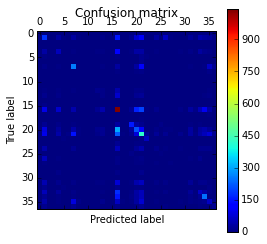

In [111]:
from sklearn.metrics import confusion_matrix
def heat_map_cm(testlabels, prediction):
    cm = confusion_matrix(testlabels, prediction)
    plt.figure(figsize = (15.0, 10.0))
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

heat_map_cm(mini_test_labels, clf.predict(mini_testX))

In [ ]:
if class_weight is not specified, 0.271. If class_weight = "auto", 0.274, If warm_start=True and class_weight = "auto", 0
0.275. If class_weight is "auto" and min_samples_leaf = 2, max_depth = 15, f1 is awful 0.15. 

In [94]:
print f1_score

0.270633633353


In [31]:
clf_probs = clf.predict_proba(testX)
print clf_probs.shape
print clf_probs[:1]

(884262, 39)
[[ 0.01709402  0.18437118  0.          0.          0.01648352  0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.28205128  0.          0.          0.05128205
   0.10683761  0.07692308  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.02564103  0.08547009
   0.          0.          0.05128205  0.05128205  0.02564103  0.02564103]]


In [ ]:
import gzip
with gzip.open('submission-matrix.csv.gz', 'wb') as f:
    out = csv.writer(f, lineterminator='\n')
    out.writerow(['Id'] + list(np.unique(crime_labels)))
    
    for i, prob in enumerate(clf_probs):
        out.writerow([i] + list(prob))
print "Job completed" 